In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

from get_data import *

### Data load

In [2]:
ds, cols_model = get_data_model_v2(k_clusters=6)
ds.info()

Database object created


c:\Users\ivan\Desktop\Coding\corunaRealEstateMarket\bd.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


Best k for clustering zones: 4
Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 723
Data columns (total 99 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   zona_cluster                                724 non-null    float64
 1   id                                          724 non-null    float64
 2   titulo                                      724 non-null    object 
 3   descripcion                                 711 non-null    object 
 4   extra_info                                  720 non-null    object 
 5   n_habitaciones                              724 non-null    float64
 6   tamano                                      724 non-null    float64
 7   precio                                      724 non-null    float64
 8   municipio        

In [3]:
object_columns = ds.select_dtypes(include=['object']).columns.tolist()
ds_object = ds[object_columns]
ds_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 723
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   titulo              724 non-null    object
 1   descripcion         711 non-null    object
 2   extra_info          720 non-null    object
 3   municipio           724 non-null    object
 4   direccion           713 non-null    object
 5   landmarks_cercanos  713 non-null    object
 6   zona                724 non-null    object
 7   zona_v2             724 non-null    object
dtypes: object(8)
memory usage: 50.9+ KB


In [4]:
cols = ds.columns
cols_exclude = ['id', 'titulo', 'descripcion', 'extra_info', 'direccion', 'landmarks_cercanos', 'municipio', 'zona', 'zona_v2', 'direccion_x', 'direccion_y']
cols_check_nas = ['n_banos', 'n_plazas_garaje', 'valoracion']
for col in cols_check_nas:
    if sum(ds[col]==-1)/len(ds) > 0.25:
        print(f'Column {col} has more than 20% of missing values.')
        cols_exclude.append(col)

cols_model = [col for col in cols if col not in cols_exclude]

#convert int and bool columns to float
for col in cols:
    if ds[col].dtype == 'int64':
        ds[col] = ds[col].astype('float64')
    elif ds[col].dtype == 'object':
        cols_exclude.append(col)
    elif ds[col].dtype == 'bool':
        ds[col] = ds[col].astype('float64')


x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']
corr = abs(x.corrwith(y)).sort_values(ascending=False)
# get cols whose corr is nan
cols_corr_nan = corr[corr.isna()].index.tolist()
for col in cols_corr_nan:
    cols_exclude.append(col)
    if col in cols_model:
        cols_model.remove(col)

Column n_banos has more than 20% of missing values.
Column n_plazas_garaje has more than 20% of missing values.


### Data exploration

Correlaciones

In [4]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']
abs(x.corrwith(y)).sort_values(ascending=False)[0:50]

precio_m2_medio_cluster*tam               0.685521
puntuacion_lujo_2*tam                     0.685265
tamano                                    0.660742
puntuacion_lujo*tam                       0.644710
puntuacion*tam                            0.635717
tamano^2                                  0.611501
es_chalet*tam                             0.512416
puntuacion_lujo_2                         0.503599
es_chalet                                 0.496969
es_casa                                   0.492154
puntuacion_lujo                           0.449592
n_habitaciones                            0.436049
palabras_bonitas*tam                      0.427298
puntuacion                                0.424115
oleiros*tam                               0.408521
exclusivo*tam                             0.377871
vistas                                    0.373775
piscina*tam                               0.332444
centro_coruna*tam                         0.315384
zona_cluster_5                 

### Deal with NAs

In [6]:
for col in cols_check_nas:
    ds[col] = ds[col].fillna(np.mean(ds[col]))

### Data split

In [5]:
x = ds[cols_model].drop('precio', axis=1)
y = ds['precio']

# slit data into train and val
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Model: Linear reg

In [6]:
def train_model(x,y, model, n_splits=5, n_repeats=5, print_results=False):
    return_val = []
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    rkf.get_n_splits(x, y)
    for i, (train_index, val_index) in enumerate(rkf.split(x)):
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        x_val = x.iloc[val_index]
        y_val = y.iloc[val_index]
        model.fit(x_train, y_train)
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred) 
        return_val.append({'rmse_train': rmse_train, 'rmse_val': rmse_val, 'mae_train': mae_train, 'mae_val': mae_val})
    if print_results:
        rmse_train = [x['rmse_train'] for x in return_val]
        rmse_val = [x['rmse_val'] for x in return_val]
        mae_train = [x['mae_train'] for x in return_val]
        mae_val = [x['mae_val'] for x in return_val]

        print(f'RMSE train:\t mean {np.mean(rmse_train):.2f}\t std {np.std(rmse_train):.2f}')
        print(f'RMSE val:\t mean {np.mean(rmse_val):.2f}\t std {np.std(rmse_val):.2f}')
        print("")
        print(f'MAE train:\t mean {np.mean(mae_train):.2f}\t std {np.std(mae_train):.2f}')
        print(f'MAE val:\t mean {np.mean(mae_val):.2f}\t std {np.std(mae_val):.2f}')
    return return_val

#### Linear reg

Repeated CV

In [8]:
trainings = train_model(x,y, LinearRegression(), n_splits=5, n_repeats=5, print_results=True)

RMSE train:	 mean 259.41	 std 12.98
RMSE val:	 mean 379.69	 std 67.10

MAE train:	 mean 168.10	 std 5.48
MAE val:	 mean 216.51	 std 20.51


LeaveOneOut

In [16]:
trainings = train_model(x,y, LinearRegression(), n_splits=len(x), n_repeats=1, print_results=True)

RMSE train:	 mean 275.04	 std 1.03
RMSE val:	 mean 208.81	 std 285.42

MAE train:	 mean 174.07	 std 0.45
MAE val:	 mean 208.81	 std 285.42


#### Variable selection

In [9]:
def get_step_score(current_cols, new_col, x, y, model):
    cols = current_cols + [new_col]
    trainings = train_model(x[cols],y, model)
    rmse_train = [x['rmse_train'] for x in trainings]
    rmse_train = np.mean(rmse_train)
    rmse_val = [x['rmse_val'] for x in trainings]
    rmse_val = np.mean(rmse_val)
    return rmse_train, rmse_val

def perform_forward(x,y, model, cols_model, max_steps=50):
    current_cols = []
    scores_train = []
    scores_val = []
    cols = []
    all_columns = cols_model[:]
    all_columns.remove('precio')

    for k in range(min(len(all_columns)-1,max_steps)):
        best_col = None
        best_score_training = 1e20
        best_score_val = 1e20
        best_model = None
        for col in set(all_columns)-set(current_cols):
            score_training, score_val = get_step_score(current_cols, col, x, y, model)
            if score_training < best_score_training:
                best_score_training = score_training
                best_score_val = score_val
                best_col = col
        current_cols.append(best_col)
        scores_train.append(best_score_training)
        scores_val.append(best_score_val)
        cols.append(current_cols[:])
        print(f'Best column: {best_col}\t score training:{best_score_training:.2f}\t score_val:{score_val:.2f}')
    return cols, scores_train, scores_val, current_cols

In [10]:
cols, scores_train, scores_val, current_cols = perform_forward(x,y, LinearRegression(), cols_model, 30)

Best column: precio_m2_medio_cluster*tam	 score training:386.85	 score_val:384.42
Best column: puntuacion_lujo_2*tam	 score training:353.98	 score_val:356.69
Best column: vacacional	 score training:335.99	 score_val:348.95
Best column: maianca*tam	 score training:327.90	 score_val:339.04
Best column: maianca	 score training:319.49	 score_val:335.37
Best column: sin_ascensor	 score training:313.11	 score_val:334.38
Best column: vacacional*tam	 score training:308.93	 score_val:321.06
Best column: precio_m2_medio_cluster	 score training:303.93	 score_val:369.86
Best column: es_casa	 score training:300.30	 score_val:322.78
Best column: palabras_bonitas*tam	 score training:296.37	 score_val:326.11
Best column: estudiantes*tam	 score training:294.03	 score_val:342.05
Best column: exclusivo	 score training:291.27	 score_val:319.80
Best column: de_diseño	 score training:289.17	 score_val:306.61
Best column: distancia_centro_oleiros*tam	 score training:286.77	 score_val:310.23
Best column: vist

In [138]:
selected_cols = current_cols[0:15]

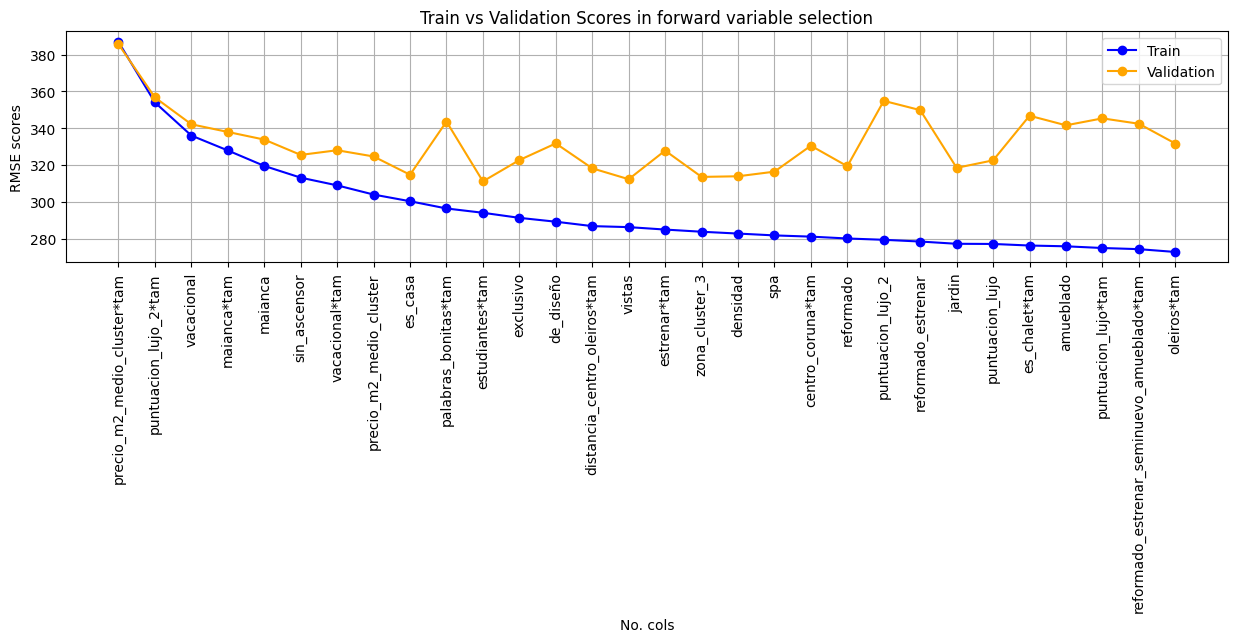

In [11]:
idx = list(range(len(current_cols)))
plt.figure(figsize=(15,3))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [140]:
xx = x[y<1500]
yy = y[y<1500]
cols, scores_train, scores_val, current_cols = perform_forward(xx,yy, LinearRegression(), cols_model)

Best column: tamano	 score training:177.39	 score_val:223.70
Best column: zona_cluster_2*tam	 score training:162.28	 score_val:176.41
Best column: sin_ascensor	 score training:155.63	 score_val:162.37
Best column: densidad	 score training:150.92	 score_val:156.48
Best column: vistas	 score training:148.24	 score_val:152.52
Best column: puntuacion	 score training:146.96	 score_val:149.99
Best column: amueblado	 score training:145.22	 score_val:148.78
Best column: tamano^2	 score training:143.64	 score_val:147.28
Best column: paseo_maritimo	 score training:142.51	 score_val:146.46
Best column: soleado	 score training:141.65	 score_val:145.09
Best column: coruna	 score training:140.85	 score_val:145.11
Best column: estudiantes	 score training:139.98	 score_val:144.16
Best column: es_chalet*tam	 score training:139.32	 score_val:142.90
Best column: parking	 score training:138.62	 score_val:143.78
Best column: vacacional	 score training:138.15	 score_val:143.95
Best column: lujo	 score train

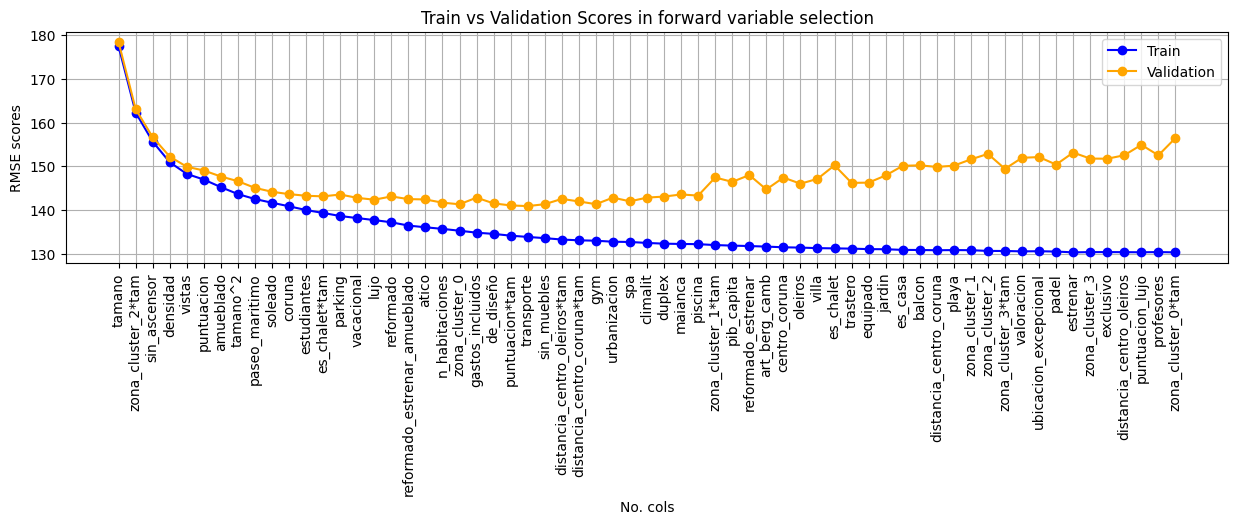

In [141]:
idx = list(range(len(current_cols)))
plt.figure(figsize=(15,3))
plt.plot(idx, scores_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(idx, scores_val, marker='o', linestyle='-', color='orange', label='Validation')

plt.xlabel('No. cols')
plt.ylabel('RMSE scores')
plt.title('Train vs Validation Scores in forward variable selection')
plt.xticks(idx, current_cols)  # Use column names as x-axis labels
#in vertical
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

#### Usando solo n_habitaciones y tamaño

In [12]:
xx = ds[['tamano', 'n_habitaciones']]
yy = ds['precio']
trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=50, print_results=True)

print("")
print("")
print("")
xx = ds[['tamano', 'n_habitaciones', 'puntuacion_lujo']]
yy = ds['precio']
trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=50, print_results=True)

RMSE train:	 mean 398.28	 std 16.73
RMSE val:	 mean 397.80	 std 66.72

MAE train:	 mean 230.20	 std 6.93
MAE val:	 mean 231.97	 std 21.76



RMSE train:	 mean 376.88	 std 17.02
RMSE val:	 mean 377.01	 std 65.29

MAE train:	 mean 227.17	 std 7.13
MAE val:	 mean 229.27	 std 21.25


#### Solo viviendas en el municipio de A Coruña

In [90]:
ds_aux = ds[ds['municipio'].str.contains('oru')]
# ds_aux = ds
xx = ds_aux[selected_cols]
yy = ds_aux['precio']

trainings = train_model(xx,yy, LinearRegression(), n_splits=5, n_repeats=50, print_results=True)

RMSE train:	 mean 251.89	 std 15.53
RMSE val:	 mean 276.38	 std 169.62

MAE train:	 mean 159.78	 std 5.54
MAE val:	 mean 171.49	 std 33.15


### Model: Lasso reg

In [14]:
lambda_vals = [0.1, 0.5, 1, 2, 4, 5, 7, 9 ,10, 15, 20, 30, 40, 50, 100]
scores_record= []
models = []

for val in lambda_vals:
    model = linear_model.Lasso(alpha=val, max_iter=10000, tol=0.1)

    rkf = RepeatedKFold(n_splits=5, n_repeats=5)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=rkf)
    scores = np.sqrt(np.abs(scores))

    scores_mean = np.mean(scores)
    scores_record.append(scores_mean)

    model.fit(x_train, y_train)
    models.append(model)
    cols_selected = x_train.columns[model.coef_ > 0.0001]
    print("lambda val: ", val, '\t', "RMSE: ", scores_mean, '\t', len(cols_selected), cols_selected.to_list())

c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+07, tolerance: 1.449e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+07, tolerance: 1.607e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

lambda val:  0.1 	 RMSE:  366.1182332518227 	 24 ['n_habitaciones', 'tamano', 'zona_cluster', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'profesores', 'es_casa', 'ubicacion_excepcional', 'atico', 'villa', 'estrenar', 'soleado', 'exclusivo', 'de_diseño', 'padel', 'gym', 'puntuacion*tam', 'coruna', 'centro_coruna', 'oleiros', 'maianca']
lambda val:  0.5 	 RMSE:  356.1267830715219 	 22 ['n_habitaciones', 'tamano', 'zona_cluster', 'densidad', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'profesores', 'es_casa', 'ubicacion_excepcional', 'atico', 'villa', 'estrenar', 'exclusivo', 'de_diseño', 'padel', 'puntuacion*tam', 'centro_coruna', 'oleiros', 'maianca']
lambda val:  1 	 RMSE:  359.286836852956 	 19 ['n_habitaciones', 'tamano', 'zona_cluster', 'densidad', 'parking', 'playa', 'balcon', 'vacacional', 'vistas', 'es_casa', 'ubicacion_excepcional', 'estrenar', 'exclusivo', 'de_diseño', 'puntuacion', 'puntuacion*tam', 'centro_coruna', 'oleiros', 'maianca']
lambda val:  2 	 R

### Model: xgboost

In [24]:
trainings = train_model(x,y, xgb.XGBRegressor(n_estimators=9, max_depth=5), n_splits=5, n_repeats=20, print_results=True)

RMSE train:	 mean 193.07	 std 10.41
RMSE val:	 mean 365.71	 std 63.65

MAE train:	 mean 119.95	 std 4.12
MAE val:	 mean 197.68	 std 23.03


In [15]:
trainings = train_model(x,y, xgb.XGBRegressor(n_estimators=500, max_depth=1), n_splits=5, n_repeats=20, print_results=True)

RMSE train:	 mean 184.89	 std 10.15
RMSE val:	 mean 344.77	 std 66.40

MAE train:	 mean 124.69	 std 4.63
MAE val:	 mean 202.54	 std 22.20


In [99]:
cols, scores_train, scores_val = perform_forward(x,y, xgb.XGBRegressor(n_estimators=3, max_depth=3), cols_model)

Best column: tamano	 score training:524.87	 score_val:617.68
Best column: puntuacion	 score training:511.41	 score_val:540.17
Best column: pib_capita	 score training:504.53	 score_val:530.59
Best column: es_casa	 score training:501.21	 score_val:522.73
Best column: distancia_centro_coruna	 score training:498.54	 score_val:528.14
Best column: vacacional	 score training:497.43	 score_val:525.59
Best column: jardin	 score training:496.99	 score_val:526.00
Best column: exclusivo	 score training:496.93	 score_val:526.49
Best column: transporte	 score training:497.02	 score_val:530.96
Best column: parking	 score training:496.88	 score_val:528.41
Best column: distancia_centro_oleiros	 score training:496.55	 score_val:528.44
Best column: valoracion	 score training:496.85	 score_val:531.25
Best column: coruna	 score training:496.63	 score_val:529.90
Best column: electrico	 score training:496.22	 score_val:530.95
Best column: playa	 score training:496.21	 score_val:529.33
Best column: n_habitaci

### Model: Random forest

In [16]:
trainings = train_model(x,y, RandomForestRegressor(max_depth=10, n_estimators = 50), n_splits=5, n_repeats=5, print_results=True)

RMSE train:	 mean 142.88	 std 6.96
RMSE val:	 mean 335.67	 std 56.65

MAE train:	 mean 90.58	 std 3.50
MAE val:	 mean 188.85	 std 19.79


In [100]:
cols, scores_train, scores_val = perform_forward(x,y, RandomForestRegressor(max_depth=10, n_estimators = 50), cols_model)

Best column: tamano	 score training:300.77	 score_val:525.52
Best column: distancia_centro_coruna	 score training:189.35	 score_val:438.28
Best column: puntuacion	 score training:173.75	 score_val:416.48
Best column: vacacional	 score training:160.68	 score_val:398.32
Best column: amueblado	 score training:157.11	 score_val:360.33
Best column: vistas	 score training:153.69	 score_val:353.36
Best column: n_habitaciones	 score training:151.91	 score_val:361.98
Best column: soleado	 score training:149.37	 score_val:349.33
Best column: coruna	 score training:148.43	 score_val:353.09
Best column: reformado	 score training:147.80	 score_val:349.19
Best column: estudiantes	 score training:147.34	 score_val:346.10
Best column: distancia_centro_oleiros	 score training:147.21	 score_val:348.65
Best column: transporte	 score training:147.86	 score_val:345.56
Best column: equipado	 score training:147.88	 score_val:345.73
Best column: paseo_maritimo	 score training:146.84	 score_val:348.32
Best col

### Model: SVM

In [111]:
from sklearn.svm import SVR
model = SVR(C=0.01, epsilon=0.1)
trainings = train_model(x,y, model, n_splits=5, n_repeats=5, print_results=True)

RMSE train:	 mean 552.24	 std 25.41
RMSE val:	 mean 543.90	 std 99.22

MAE train:	 mean 308.02	 std 10.58
MAE val:	 mean 308.08	 std 42.35


In [ ]:
cols, scores_train, scores_val = perform_forward(x,y, model, cols_model)

### Model: DNN

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


# Define the neural network architecture
model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=(x.shape[1],)),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)  # Output layer for regression (no activation function)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_scaled, y, epochs=5000, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(x_scaled, y)
test_loss = np.sqrt(test_loss)
print(f"Test loss: {test_loss}")

Epoch 1/5000
37/37 [==============================] - 1s 4ms/step - loss: 1183500.0000 - val_loss: 1160984.0000
Epoch 2/5000
37/37 [==============================] - 0s 2ms/step - loss: 1183143.2500 - val_loss: 1160602.5000
Epoch 3/5000
37/37 [==============================] - 0s 2ms/step - loss: 1182652.2500 - val_loss: 1160069.0000
Epoch 4/5000
37/37 [==============================] - 0s 2ms/step - loss: 1182001.3750 - val_loss: 1159322.5000
Epoch 5/5000
37/37 [==============================] - 0s 2ms/step - loss: 1181128.3750 - val_loss: 1158341.7500
Epoch 6/5000
37/37 [==============================] - 0s 2ms/step - loss: 1179955.1250 - val_loss: 1157000.0000
Epoch 7/5000
37/37 [==============================] - 0s 2ms/step - loss: 1178324.8750 - val_loss: 1155188.5000
Epoch 8/5000
37/37 [==============================] - 0s 2ms/step - loss: 1176027.3750 - val_loss: 1152517.8750
Epoch 9/5000
37/37 [==============================] - 0s 2ms/step - loss: 1172779.8750 - val_loss: 11490

KeyboardInterrupt: 

##### XGB

In [78]:
cols_model_binary = ['tamano','puntuacion','es_chalet', 'puntuacion_lujo','centro_coruna', 'oleiros', 'maianca', 'reformado_estrenar', 'vacacional']
xx = x[cols_model_binary].copy()
yy = y.copy()
yy = yy > 1550

In [79]:
acc_train = []
acc_val = []
f1_train = []
f1_val = []


for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2)
    class_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
    clf = xgb.XGBClassifier(
        objective='binary:logistic',  # For binary classification
        max_depth=3,  # Maximum depth of a tree
        learning_rate=0.1,  # Step size shrinkage
        n_estimators=100,  # Number of boosting rounds (trees)
        n_jobs=-1,  # Use all available cores
        random_state=42,  # For reproducibility
        scale_pos_weight=class_ratio
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, clf.predict(X_train))
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_tr = f1_score(y_train, clf.predict(X_train))
    f1_va = f1_score(y_test, y_pred)
    acc_train.append(accuracy_train)
    acc_val.append(accuracy_val)
    f1_train.append(f1_tr)
    f1_val.append(f1_va)

print(f'Accuracy train:\t mean {np.mean(acc_train):.2f}\t std {np.std(acc_train):.2f}')
print(f'Accuracy val:\t mean {np.mean(acc_val):.2f}\t std {np.std(acc_val):.2f}')
print("")
print(f'F1 train:\t mean {np.mean(f1_train):.2f}\t std {np.std(f1_train):.2f}')
print(f'F1 val:\t mean {np.mean(f1_val):.2f}\t std {np.std(f1_val):.2f}')

Accuracy train:	 mean 0.96	 std 0.01
Accuracy val:	 mean 0.92	 std 0.02

F1 train:	 mean 0.79	 std 0.03
F1 val:	 mean 0.62	 std 0.07
